In [1]:
import time
import serial
import serial.tools.list_ports
from gdx import gdx as gdx_module
import ipywidgets as widgets
import ipysheet
gdx = gdx_module.gdx()

gdx_connected=False

gdx_connect_button =  widgets.Button(
                description='Gdx Connect',
                disabled=False,
                button_style='', 
                tooltip='Connect gdx sensor',
                icon='plug' 
)
connection_output = widgets.Output(layout={'border': '2px solid black'})
connection_output.clear_output()

@connection_output.capture()
def openConnection(p):
    global gdx_connected
    gdx.open(connection='usb')
    gdx_connected=True
    print(gdx.find_devices())
    print("Connected")
    
gdx_connect_button.on_click(openConnection)
widgets.VBox([gdx_connect_button,connection_output])


In [2]:
gdx__hall_sensor_button = widgets.Button(
    description='Query info',
    disabled=False,
    button_style='', 
    tooltip='Hall Sensor informations',
    icon='plug' 
)

hall_output = widgets.Output(layout={'border': '2px solid black'})

def getSensorInfo():
    available_sensors=[]
    if not gdx_connected: 
        return ["Not Connected"]
    for i,myinfo in enumerate(gdx.sensor_info()):
        info=f"{myinfo[0]} {myinfo[1]}"
        available_sensors.append((info,i+1))
    return(available_sensors)
    
gdx_sensors=widgets.Dropdown(
    options=getSensorInfo(),
    description='Available sensors:',
    disabled=False
)


gdx_active_sensors=widgets.SelectMultiple(
    options=getSensorInfo(),
    rows=10,
    description='Available sensors',
    disabled=False,
    layout={'width': 'max-content'}
)


gdx_active_sensors.style.description_width='150px'
gdx_sensors.style.description_width='150px'


@hall_output.capture()
def getDeviceInfo(p):
    if not gdx_connected:
        print("Not connected yet!")
        return
    for myinfo in gdx.device_info():
        print(myinfo)
    
gdx__hall_sensor_button.on_click(getDeviceInfo)

def selectSensors():
    if len(gdx_active_sensors.value)>0:
        #gdx.select_sensors(gdx_active_sensors.value)
        column_headers = gdx.enabled_sensor_info()
        return column_headers
    return None


commands_elements=widgets.HBox([gdx_active_sensors,gdx__hall_sensor_button])
widgets.VBox([commands_elements,hall_output])


In [5]:
def getUnits(info_headers):
    unit_list = []
    units = ''
    for headers in info_headers:
        units = str(headers[headers.find('(') : headers.find(')') +1])
        unit_list.append(units)
    return unit_list
def getMeasurement(samples,channels):
     
    gdx.select_sensors([1])
    
    deltaT=500
    gdx.start(deltaT)
    #data=[0]*len(channels)
    n=0
    for i in range(0,samples*2):
            new_data=gdx.read()
            if i>samples:
                n+=1
                #print(str(i)+" "+str(new_data))
                #data = [sum(z) for z in zip(new_data, data)]
    
    gdx.stop()
    
    data=''
    data=[m/n for m in data]
    return data

In [6]:
samples=widgets.Dropdown(
    options=range(1,16),
    description='Samples (number):',
    disabled=False,
)
samples.style.description_width='150px'
field_output = widgets.Output(layout={'border': '2px solid black'})

field_output.clear_output()

@field_output.capture()
def getFieldMeasurement(p):
    
    sensor_columns=selectSensors()
    readings=''
    if sensor_columns:
        pass
        readings=getMeasurement(samples.value,sensor_columns)
    else:
        print("Cannot get sensors informations")
        readings=None
   
    return readings

measure_button = widgets.Button(
    description='Measure field',
    disabled=False,
    button_style='', 
    tooltip='Get a single illuminance reading',
    icon='ruler'
)

measure_button.on_click(getFieldMeasurement)


interface_field=widgets.HBox([samples,measure_button])
widgets.VBox([interface_field,field_output])




In [21]:
com_ports=serial.tools.list_ports.comports()


com_port=widgets.Dropdown(
    options=[p.device for p in com_ports if "USB" in p.device or "ACM" in p.device or "COM" in p.device],
    description='Virtual serial device:',
    disabled=False
)
com_port.style.description_width='150px'
display(com_port)

Dropdown(description='Virtual serial device:', options=('/dev/ttyUSB0',), style=DescriptionStyle(description_w…

In [14]:
arduino_connect_button = widgets.Button(
    description='Connect',
    disabled=False,
    button_style='', 
    tooltip='Start Arduino connection',
    icon='plug' 
)

output = widgets.Output(layout={'border': '2px solid black'})

arduino=None

def connect_arduino(b):
    global arduino
    arduino=serial.Serial(com_port.value, baudrate=115200, timeout=1)
    test=2
    with output:
        print("Arduino connected")

arduino_connect_button.on_click(connect_arduino)
display(arduino_connect_button,output)


Button(description='Connect', icon='plug', style=ButtonStyle(), tooltip='Start Arduino connection')

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

In [15]:
button_widgets=[]
buttons_output = widgets.Output(layout={'border': '2px solid black'})
buttons_output.clear_output()

buttons={'Handshake':{'tooltip':'Handshake','command':'h','icon':'handshake'},
         'Motor home':{'tooltip':'Motor home','command':'w','icon':'house'},
         'End home':{'tooltip':'End home','command':'x','icon':'flag-checkered'},
         'Calibrate':{'tooltip':'Calibrate homes','command':'c','icon':'gear'},
         'Ping':{'tooltip':'Ping microcontroller','command':'p','icon':'reply'},
         'Forward 1':{'tooltip':'Forward 1 turn','command':'f','icon':'forward'},
         'Backward 1':{'tooltip':'Backward 1 turn','command':'b','icon':'backward'},
         'Get pos':{'tooltip':'Get Position','command':'g','icon':'asterisk'},
         'Stop status':{'tooltip':'Get stop status','command':'e','icon':'stop'},
         'Max pos':{'tooltip':'Get Max Position','command':'a','icon':'maximize'}
            }

@buttons_output.capture()
def send_microcontroller_command(button):
    
    command=buttons[button.description]['command']
    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write(command.encode())
    while (arduino.in_waiting < 0):
        pass
    out_message=''
    response=''
    while True:
        response= arduino.read_until()
        time.sleep(0.1)
        if  response.decode().strip()=='executed':
            break
        out_message+=response.decode().strip()
        if len(response.decode().strip())>0:
            print(response.decode().strip())
        else:
            print("- ")
    arduino.timeout = timeout
    return out_message

for button in buttons.keys():
    new_button=widgets.Button(
                            description=button,
                            disabled=False,
                            button_style='', 
                            tooltip=buttons[button]['tooltip'],
                            icon=buttons[button]['icon'],
            )
    new_button.on_click(send_microcontroller_command)
    button_widgets.append(new_button)




        

    


buttons_w=widgets.HBox([button for button in button_widgets])
widgets.VBox([buttons_w,buttons_output])


In [49]:
def move():
    pass

In [40]:
positions = []
field= []
def daq_get_values(start_position=0.0,end_position=0.5,step=0.1):

    
    position=0.0
    
    # send movement command
    
    
    while position <= end_position:
        positions.append(position)
        field.append(getMeasurement(10,column_headers))  
        movement_command="q"+str(step)
        arduino.write(movement_command.encode())
        position+=step
    

In [49]:
daq_get_values(0.0,0.6,0.1)

In [50]:
print(field)

[[0.011579333080185784, 0.001177833402632839, -0.053481163250075445], [0.011512666423287656, 0.0010445000500314766, -0.05363116537531217], [0.0117293330323365, 0.0014111666241660714, -0.053564498821894325], [-0.0015540003466109435, 0.028444499812192388, -0.050547832830084696], [-0.06440400332212448, 0.03032783232629299, -0.01273116593559583], [-0.0714540026254124, 0.023211166883508366, -0.01886449878414472], [-0.0676706689927313, 0.027761166501376364, -0.015681165373987623], [-0.040004000481632024, 0.040077833665741816, 0.0010521676716355917], [-0.0338373347508928, 0.001061166636645794, -0.04546449954311053], [-0.04285400130579041, -0.02338883363538318, -0.04491450016697248]]


In [22]:
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'

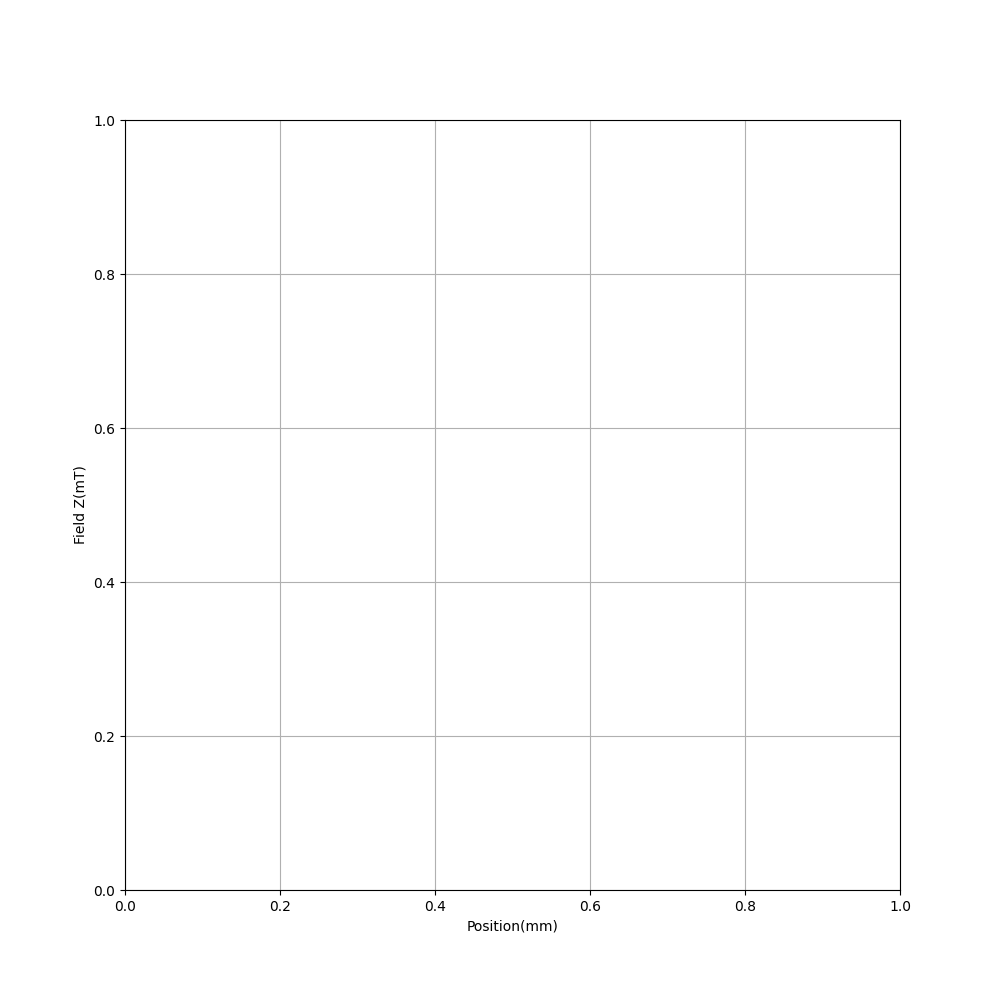

In [23]:
def new_figure():
    fig=plt.figure(figsize=[10,10])
    plt.grid()
    plt.xlabel('Position(mm)')
    plt.ylabel('Field Z(mT)')
    #plt.rcParams['figure.dpi'] = 150
    return fig
fig=new_figure()

In [51]:
plt.plot(positions,[row[0] for row in field],'-o',color='gray',markerfacecolor='red')